<a href="https://colab.research.google.com/github/KacWasilewski/KW_AI_Programming/blob/main/https_github_com_KacWasilewski_KW_AI_Programming.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Instalacja Poppler (wymagane dla pdf2image)
!apt-get install -y poppler-utils

import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
from pdf2image import convert_from_path

# Parametry do detekcji czarnych ścian
MIN_CONTOUR_AREA = 500
EPSILON_FACTOR = 0.01
MIN_CORNER_DISTANCE = 10
WALL_THRESHOLD = 50
FILL_THRESHOLD = 0.85
GAMMA = 0.5

# Parametry poziomów
INPUT_BLACK = 50
INPUT_WHITE = 150
OUTPUT_BLACK = 0
OUTPUT_WHITE = 255

# Funkcja do regulacji poziomów
def adjust_levels(image, in_black=0, in_white=255, out_black=0, out_white=255):
    in_black = max(0, min(in_black, 255))
    in_white = max(0, min(in_white, 255))
    out_black = max(0, min(out_black, 255))
    out_white = max(0, min(out_white, 255))

    table = np.zeros(256, dtype=np.uint8)
    for i in range(256):
        if i <= in_black:
            table[i] = out_black
        elif i >= in_white:
            table[i] = out_white
        else:
            scale = (i - in_black) / (in_white - in_black)
            table[i] = int(out_black + scale * (out_white - out_black))

    return cv2.LUT(image, table)

# Funkcja do korekcji gamma
def adjust_gamma(image, gamma=1.0):
    inv_gamma = 1.0 / gamma
    table = np.array([((i / 255.0) ** inv_gamma) * 255 for i in np.arange(0, 256)]).astype("uint8")
    return cv2.LUT(image, table)

# Ścieżka do pliku PDF
pdf_path = "/content/Apartment_plan_KW.pdf"

# Konwersja PDF na obraz
pages = convert_from_path(pdf_path, dpi=300)
image = np.array(pages[0])
image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

# Przetwarzanie obrazu
image = adjust_levels(image, in_black=INPUT_BLACK, in_white=INPUT_WHITE, out_black=OUTPUT_BLACK, out_white=OUTPUT_WHITE)
image = adjust_gamma(image, GAMMA)

# Binaryzacja obrazu
_, binary = cv2.threshold(image, WALL_THRESHOLD, 255, cv2.THRESH_BINARY)

# Operacje morfologiczne
kernel = np.ones((5,5), np.uint8)
binary = cv2.morphologyEx(binary, cv2.MORPH_CLOSE, kernel)
binary = cv2.morphologyEx(binary, cv2.MORPH_OPEN, kernel)

# Odwrócenie kolorów
binary = cv2.bitwise_not(binary)

# Wyszukiwanie konturów
contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Wizualizacja
plt.figure(figsize=(12, 8))
plt.imshow(binary, cmap='gray')

# Zapis obrazu
output_png_filename = "/content/detected_walls.png"
plt.axis('off')
plt.savefig(output_png_filename, bbox_inches='tight', pad_inches=0)
plt.close()

print(f"PNG saved as: {output_png_filename}")




Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
poppler-utils is already the newest version (22.02.0-2ubuntu0.6).
0 upgraded, 0 newly installed, 0 to remove and 29 not upgraded.
PNG saved as: /content/detected_walls.png


In [ ]:
import os

scripts = ["image_adjustment.py", "redraw_walls.py", "space_detection.py"]

print("Starting the pipeline...\n")

for script in scripts:
    print(f"Running {script}...")
    exit_code = os.system(f"python {script}")

    if exit_code != 0:
        print(f"Error: {script} encountered an issue. Exiting pipeline.")
        break
    print(f"{script} completed successfully.\n")

print("Pipeline execution finished.")

Starting the pipeline...

Running image_adjustment.py...
Error: image_adjustment.py encountered an issue. Exiting pipeline.
Pipeline execution finished.


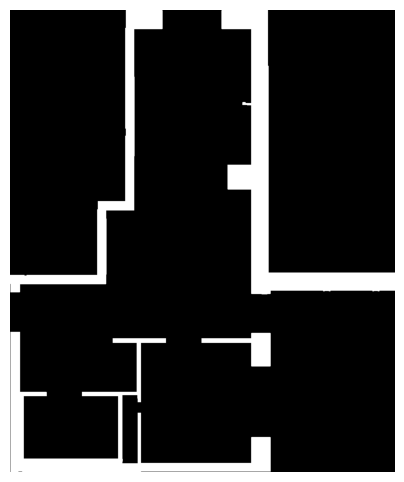

'/mnt/data/cropped_walls.png'

In [ ]:

def extract_floor_plan(image, output_path):
    # Znalezienie konturów białych obszarów (rzut mieszkania)
    contours, _ = cv2.findContours(image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Filtrowanie konturów - usunięcie małych elementów poza centralnym rysunkiem
    min_contour_area = 5000  # Można dostosować w zależności od obrazu
    filtered_contours = [cnt for cnt in contours if cv2.contourArea(cnt) > min_contour_area]

    # Utworzenie nowego obrazu, gdzie zostaną narysowane tylko wycięte linie rzutu mieszkania
    mask = np.zeros_like(image)
    cv2.drawContours(mask, filtered_contours, -1, (255), thickness=cv2.FILLED)

    # Przycięcie obrazu do rozmiaru rzutu mieszkania
    x, y, w, h = cv2.boundingRect(mask)
    cropped = mask[y:y+h, x:x+w]

    # Zapisz wycięty obraz
    cv2.imwrite(output_path, cropped)

    # Wyświetlenie wyniku
    plt.figure(figsize=(8, 6))
    plt.imshow(cropped, cmap='gray')
    plt.axis('off')
    plt.show()

    return output_path

# Przykładowe użycie
output_image_path = "/mnt/data/cropped_walls.png"
extract_floor_plan(binary, output_image_path)

In [30]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import svgwrite
import os

# Pobranie bieżącego katalogu (poprawiona wersja)
current_dir = os.getcwd()

# Wczytanie obrazu
image_path = os.path.join(current_dir, "detected_walls.png")
image = cv2.imread(image_path)

if image is None:
    raise FileNotFoundError(f"Nie znaleziono pliku: {image_path}")

gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Poprawione parametry wykrywania narożników
max_corners = 2000
quality_level = 0.0001
min_distance = 1
block_size = 3
k = 0.04

# Tworzenie pliku SVG
height, width = image.shape[:2]
svg_path = os.path.join(current_dir, "vector_walls.svg")
dwg = svgwrite.Drawing(svg_path, size=(width, height), profile='tiny')

# Przetwarzanie obrazu binarnego
_, binary = cv2.threshold(gray, 160, 255, cv2.THRESH_BINARY)
kernel = np.ones((3, 3), np.uint8)
binary = cv2.morphologyEx(binary, cv2.MORPH_CLOSE, kernel)
binary = cv2.morphologyEx(binary, cv2.MORPH_OPEN, kernel)

# Znalezienie konturów
contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_TC89_L1)

# Tworzenie nowego obrazu do zapisu PNG
output_image = np.ones((height, width, 3), dtype=np.uint8) * 255

# Przetwarzanie każdego konturu
for contour in contours:
    epsilon = 0.001 * cv2.arcLength(contour, True)
    approx = cv2.approxPolyDP(contour, epsilon, True)

    if len(approx) >= 3:
        filtered_points = []
        min_dist_threshold = 2

        for i, point in enumerate(approx):
            point = point[0]
            too_close = False
            for existing_point in filtered_points:
                dist = np.sqrt(np.sum((point - existing_point) ** 2))
                if dist < min_dist_threshold:
                    too_close = True
                    break
            if not too_close:
                filtered_points.append(point)

        if len(filtered_points) >= 3:
            points = filtered_points

            # Rysowanie ścian na obrazie PNG
            points_array = np.array(points)
            cv2.polylines(output_image, [points_array], True, (0, 0, 0), 1)

            # Rysowanie narożników na PNG
            for point in points:
                cv2.circle(output_image, tuple(point), 2, (255, 0, 0), -1)

            # Tworzenie ścian w SVG
            path_data = f"M {points[0][0]},{points[0][1]}"
            for point in points[1:]:
                path_data += f" L {point[0]},{point[1]}"
            path_data += " Z"

            path = dwg.path(d=path_data, stroke='black', fill='none', stroke_width=1)
            dwg.add(path)

            # Dodanie narożników w SVG
            for point in points:
                dwg.add(dwg.circle(center=(str(point[0]), str(point[1])), r=2, fill='red'))

# Zapisz pliki SVG i PNG
output_vector_path = os.path.join(current_dir, "vector_walls.svg")
output_png_path = os.path.join(current_dir, "vector_walls.png")

dwg.save()
cv2.imwrite(output_png_path, output_image)

print(f"Vector drawing complete. Files saved as:")
print(f"SVG: {output_vector_path}")
print(f"PNG: {output_png_path}")


Vector drawing complete. Files saved as:
SVG: /content/vector_walls.svg
PNG: /content/vector_walls.png


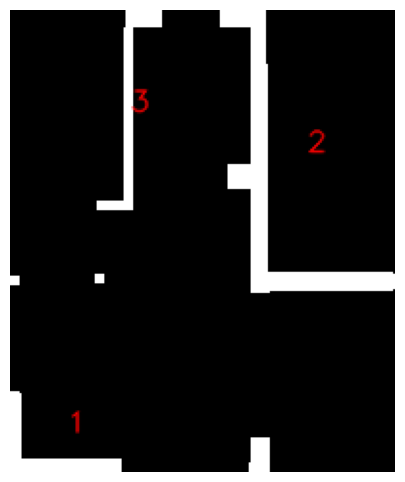

,Room,X,Y,Width,Height,Area_m2
0,1,0,198,58,42,1.13
1,2,109,0,91,147,4.39
2,3,45,0,34,104,1.27


Labeled image saved as: /mnt/data/labeled_rooms.png


In [55]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Ścieżka do pliku wejściowego
input_image_path = "/content/cropped_walls.png"
output_image_path = "/mnt/data/labeled_rooms.png"

# Wczytanie obrazu
image = cv2.imread(input_image_path, cv2.IMREAD_GRAYSCALE)
if image is None:
    raise FileNotFoundError(f"Nie można wczytać obrazu: {input_image_path}")

# Binaryzacja obrazu
_, binary = cv2.threshold(image, 128, 255, cv2.THRESH_BINARY)

# Znalezienie konturów
contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Filtrowanie konturów - eliminacja bardzo małych obiektów
min_contour_area = 200  # Minimalna powierzchnia pokoju w pikselach (zmniejszona dla mniejszych pomieszczeń)
filtered_contours = [cnt for cnt in contours if cv2.contourArea(cnt) > min_contour_area]

# Tworzenie obrazu do rysowania numeracji
labeled_image = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)

# Skala przeliczeniowa na podstawie szerokości drzwi (107 cm)
door_width_px = 50  # Przybliżona szerokość drzwi w pikselach (dostosuj do obrazu)
scale_factor = 107 / door_width_px  # Skala do przeliczania pikseli na cm

# Lista przechowująca dane o pokojach
rooms = []

# Numerowanie pokoi
for i, cnt in enumerate(filtered_contours):
    area_px = cv2.contourArea(cnt)
    x, y, w, h = cv2.boundingRect(cnt)
    area_m2 = (area_px / (scale_factor ** 2)) / 100  # Przeliczenie na metry kwadratowe

    # Dodanie informacji o pokoju do listy
    rooms.append({"Room": i+1, "X": x, "Y": y, "Width": w, "Height": h, "Area_m2": round(area_m2, 2)})

    # Umieszczenie numeru pokoju na środku, z mniejszym rozmiarem czcionki
    center_x = x + w // 2
    center_y = y + h // 2
    cv2.putText(labeled_image, str(i+1), (center_x, center_y),
                cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1, cv2.LINE_AA)

# Zapisanie obrazu z ponumerowanymi pokojami
cv2.imwrite(output_image_path, labeled_image)

# Wyświetlenie obrazu
plt.figure(figsize=(8, 6))
plt.imshow(cv2.cvtColor(labeled_image, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

# Konwersja listy pokoi do tabeli
rooms_df = pd.DataFrame(rooms)

# Wyświetlenie tabeli
from IPython.display import display

display(rooms_df)

print(f"Labeled image saved as: {output_image_path}")


